<a href="https://colab.research.google.com/github/pranjalkar99/cicflowmeter-python-updated-2024/blob/master/BiGAN_anomaly_detection_acc91_12_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook tends to:
1. train generator and encoder 5 times after training discriminator for once; It helps generator  and encoder to catch up the discriminator.

It seems the accuracy has improved a little. The final accuracy is 91.12%.

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LeakyReLU, Reshape
from keras.callbacks import EarlyStopping
from keras.utils import get_file
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
# from keras.utils.vis_utils import plot_model
import os
%matplotlib inline

In [13]:
!chmod 600 /root/.kaggle/kaggle.json

In [17]:
%cd /content
!ls

/content
kaggle.json  sample_data


In [18]:
!kaggle datasets download -d hassan06/nslkdd --force

 36% 5.00M/13.9M [00:00<00:00, 48.6MB/s]
100% 13.9M/13.9M [00:00<00:00, 74.2MB/s]


In [ ]:
!unzip -o /content/nslkdd.zip -d /content/data


In [6]:
try:
    path = get_file('NSL-KDD.zip', origin='https://205.174.165.80/CICDataset/NSL-KDD/Dataset/NSL-KDD.zip')
    print(path)
except:
    print("Error downloading")

Error downloading


In [33]:
filespath = os.path.dirname("./content/data/nsl-kdd/")
# with ZipFile(path, 'r') as zipObj:
#     zipObj.extractall(filespath)
#     print(zipObj.namelist())

In [35]:
df_train = pd.read_csv("/content/data/KDDTrain+_20Percent.txt", delimiter=',', header=None)
df_test = pd.read_csv("/content/data/KDDTest-21.txt",delimiter=',', header=None)

## Data mining and exploration

In [36]:
# The CSV file has no column heads, so add them
df_train.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome',
    'difficulty'
]
df_test.columns = df_train.columns

In [37]:
print(f"df_train.shape = {df_train.shape}")
print(f"df_test.shape = {df_test.shape}")

df_train.shape = (25192, 43)
df_test.shape = (11850, 43)


In [38]:
df_obj_col = df_train.select_dtypes(include='object').columns
print(df_obj_col)

Index(['protocol_type', 'service', 'flag', 'outcome'], dtype='object')


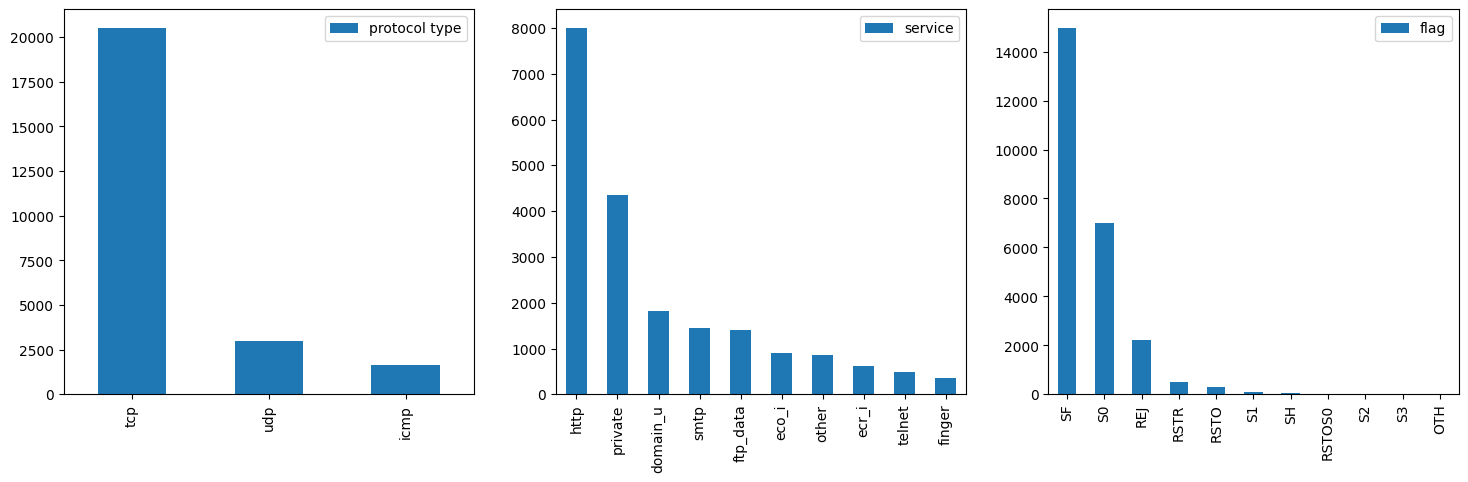

In [39]:
plt.figure(figsize=(18, 5))
plt.subplot(131)
df_train["protocol_type"].value_counts().plot(kind='bar', label='protocol type')
plt.legend()
plt.subplot(132)
df_train['service'].value_counts().head(10).plot(kind='bar')
plt.legend()
plt.subplot(133)
df_train["flag"].value_counts().plot(kind='bar')
plt.legend()
plt.show()

In [40]:
df_train['label'] = np.where(df_train['outcome'].str.contains('normal'), 0, 1)
df_test['label'] = np.where(df_test['outcome'].str.contains('normal'), 0, 1)

In [41]:
df_train_obj = df_train.iloc[:, :-3].select_dtypes(include='object')
df_train_num = df_train.iloc[:, :-3].select_dtypes(exclude='object')

print(f"shape of numeric features: {df_train_num.shape}")
print(f"shape of object features: {df_train_obj.shape}")

shape of numeric features: (25192, 38)
shape of object features: (25192, 3)


In [42]:
df_test_obj = df_test.iloc[:, :-3].select_dtypes(include='object')
df_test_num = df_test.iloc[:, :-3].select_dtypes(exclude='object')

print(f"shape of numeric features: {df_test_num.shape}")
print(f"shape of object features: {df_test_obj.shape}")

shape of numeric features: (11850, 38)
shape of object features: (11850, 3)


# Data Preprocessing

In [43]:
enc = OneHotEncoder(handle_unknown='ignore')
X_train_enc = enc.fit_transform(df_train_obj)
# X_train = np.c_[df_train_num, X_train_enc.toarray()]
X_train = np.c_[df_train_num, X_train_enc.toarray()][df_train.outcome == 'normal']
X_test_enc = enc.transform(df_test_obj)
X_test = np.c_[df_test_num, X_test_enc.toarray()]
# X_test_enc = enc.transform(df_test_obj)
X_test_normal = np.c_[df_test_num, X_test_enc.toarray()][df_test.outcome == 'normal']
X_test_abnormal = np.c_[df_test_num, X_test_enc.toarray()][df_test.outcome != 'normal']


# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [44]:
print(f"shape of X_train: {X_train.shape}")
print(f"shape of X_test: {X_test.shape}")
print(f"shape of X_test_normal: {X_test_normal.shape}")
print(f"shape of X_test_abnormal: {X_test_abnormal.shape}")

shape of X_train: (13449, 118)
shape of X_test: (11850, 118)
shape of X_test_normal: (2152, 118)
shape of X_test_abnormal: (9698, 118)


In [45]:
outlier_fence_95 = np.percentile(X_train, 95, axis=0)
X_train_new = X_train.copy()
for index, fence in enumerate(outlier_fence_95):
    boolarr = X_train_new[:,index] <= fence
    X_train_new = X_train_new[boolarr]
X_train_new.shape

(7829, 118)

In [ ]:
# # y_train = df_train['label']
# y_train = np.zeros((X_train.shape[0],1))
# y_test = df_test['label']

In [46]:
# from sklearn.preprocessing import RobustScaler, MinMaxScaler
# # scaler = RobustScaler()
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_new)
X_test_scaled = scaler.transform(X_test)
X_test_normal_scaled = scaler.transform(X_test_normal)
X_test_abnormal_scaled = scaler.transform(X_test_abnormal)
y_train = np.zeros((X_train_scaled.shape[0],1))
y_test = df_test['label']

# Model Establishing

In [51]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, concatenate
from keras.layers import LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
from keras.initializers import RandomNormal
# from keras.utils.vis_utils import plot_model
import keras.backend as K
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                3936      
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 4266 (16.66 KB)
Trainable params: 4266 (16.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


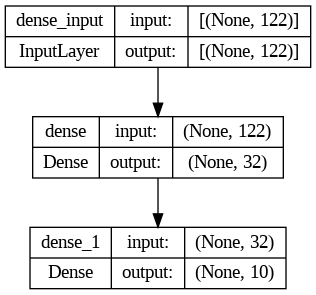

In [52]:
optimizer = Adam(0.001, 0.5)
instance_shape = 122
latent_dim = 10
initializer = RandomNormal(mean=0., stddev=1.)
encoder = Sequential()
encoder.add(Dense(32, activation='relu', input_shape=(instance_shape,), kernel_initializer=initializer))
encoder.add(Dense(latent_dim, activation='relu'))
encoder.summary()
plot_model(encoder, to_file='e_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                352       
                                                                 
 dense_3 (Dense)             (None, 122)               4026      
                                                                 
Total params: 4378 (17.10 KB)
Trainable params: 4378 (17.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


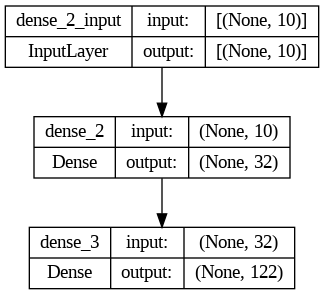

In [53]:
generator = Sequential()
generator.add(Dense(32, activation='relu', input_dim=latent_dim, kernel_initializer=initializer))
generator.add(Dense(instance_shape, activation='sigmoid'))
generator.summary()
plot_model(generator, to_file='g_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 122)]                0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 132)                  0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 dense_4 (Dense)             (None, 32)                   4256      ['concatenate[0][0]']     

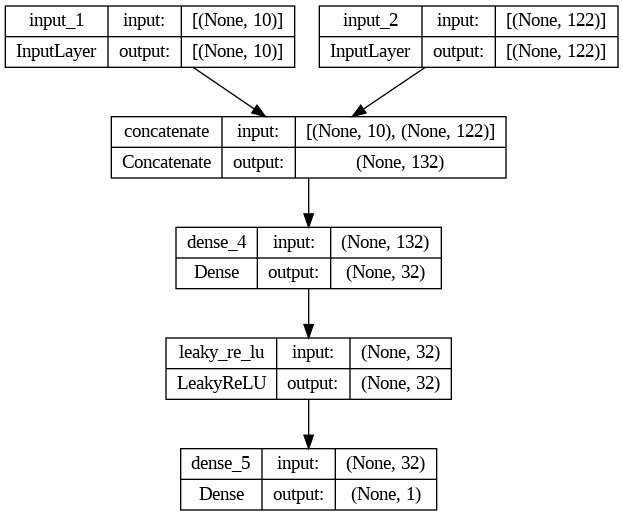

In [54]:
z = Input(shape=(latent_dim, ))
img = Input(shape=(instance_shape,))
d_in = concatenate([z, img])
model = Dense(32, kernel_initializer=initializer)(d_in)
model = LeakyReLU(alpha=0.2)(model)
validity = Dense(1, activation="sigmoid")(model)
discriminator = Model([z, img], validity)
discriminator.trainable = True
discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])
discriminator.summary()
plot_model(discriminator, to_file='d_model_plot.png', show_shapes=True, show_layer_names=True)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 122)]                0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 122)                  4378      ['input_3[0][0]']             
                                                                                                  
 sequential (Sequential)     (None, 10)                   4266      ['input_5[0][0]']             
                                                                                            

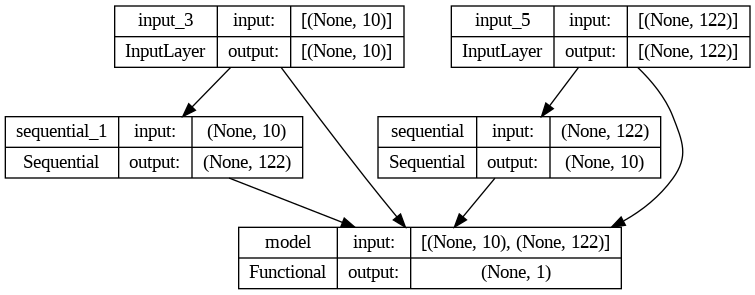

In [55]:
discriminator.trainable = False
# Generate traffic record from sampled noise
z = Input(shape=(latent_dim,))
img_ = generator(z)
# Encode traffic records to generate latent space
img = Input(shape=(instance_shape,))
z_ = encoder(img)
# Encode traffic records to generate latent space
img = Input(shape=(instance_shape,))
z_ = encoder(img)

# Latent -> img is fake, and img -> latent is valid
fake = discriminator([z, img_])
valid = discriminator([z_, img])
bigan_generator = Model([z, img], [fake, valid])
bigan_generator.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
            optimizer=optimizer)
bigan_generator.summary()
plot_model(bigan_generator, to_file='biganG_model_plot.png', show_shapes=True, show_layer_names=True)

In [56]:
# X_train = X_train_scaled
# Adversarial ground truths
batch_size=64
valid = np.zeros((batch_size, 1))
fake = np.ones((batch_size, 1))
epoches = 1000
sample_interval=10

for epoch in range(epoches):
    # ---------------------
    #  Train Discriminator
    # ---------------------
    discriminator.trainable = True
    # Sample noise and generate img
    z = np.random.normal(size=(batch_size, latent_dim))
    imgs_ = generator.predict(z)

    # Select a random batch of images and encode
    idx = np.random.randint(0, X_train_scaled.shape[0], batch_size)
    imgs = X_train_scaled[idx]
    z_ = encoder.predict(imgs)

    # Train the discriminator (img -> z is valid, z -> img is fake)
    d_loss_real = discriminator.train_on_batch([z_, imgs], valid)
    d_loss_fake = discriminator.train_on_batch([z, imgs_], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    # ---------------------
    #  Train Generator
    # ---------------------

    # Train the generator (z -> img is valid and img -> z is is invalid)
    discriminator.trainable = False
    for i in range(5):
        g_loss = bigan_generator.train_on_batch([z, imgs], [valid, fake])

    # Plot the progress
    if epoch % sample_interval == 0:
        print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))


2/2 [==============================] - 1s 5ms/step


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 122), found shape=(32, 118)


In [ ]:
# bigan = BIGAN()
# bigan.train(X_train=X_train_scaled, epochs=400, batch_size=256, sample_interval=10)

In [ ]:
# evaluate the discriminator
z_test_normal = encoder.predict(X_test_normal_scaled)
y_test_normal = np.zeros((X_test_normal_scaled.shape[0], 1))
discriminator.evaluate([z_test_normal, X_test_normal_scaled], y_test_normal)

9711/9711 [==============================] - 1s 59us/step


[3.6536852549222556, 0.809597373008728]

In [ ]:
z_test_abnormal = encoder.predict(X_test_abnormal_scaled)
y_test_abnormal = np.ones((X_test_abnormal_scaled.shape[0], 1))
discriminator.evaluate([z_test_abnormal, X_test_abnormal_scaled], y_test_abnormal)

12833/12833 [==============================] - 1s 40us/step


[0.18284065657418877, 0.9880776405334473]

In [ ]:
z_test = encoder.predict(X_test_scaled)
discriminator.evaluate([z_test, X_test_scaled], y_test)

22544/22544 [==============================] - 1s 41us/step


[1.6779334623607192, 0.9111958742141724]

In [ ]:
# encoder.save("BiGAN_encoder.hdf5")
# generator.save("BiGAN_generator.hdf5")
# discriminator.save("BiGAN_discriminator.hdf5")
# bigan_generator.save("BiGAN_bigan.hdf5")

/opt/anaconda3/envs/credit60/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


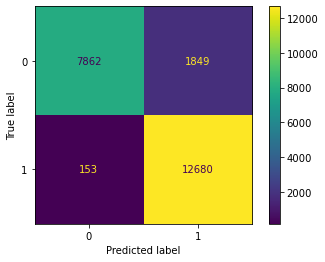

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = discriminator.predict([z_test, X_test_scaled])
cm = confusion_matrix(y_test, y_pred>0.5)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred>0.5).ravel()
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [ ]:
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)
Accuracy = (tp + tn) / (tp + tn + fp + fn)
F1 = 2 * Precision * Recall / (Precision + Recall)
print(f"Precision = {Precision}")
print(f"Recall = {Recall}")
print(f"Accuracy = {Accuracy}")
print(f"F1 = {F1}")

Precision = 0.8727372840525844
Recall = 0.9880776124055171
Accuracy = 0.9111958836053939
F1 = 0.9268328338571742


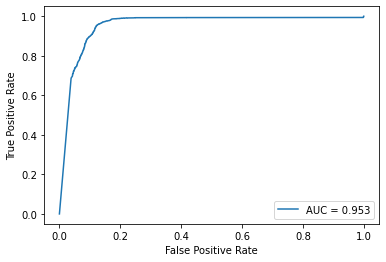

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:0.3f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()